In [2]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import numpy.fft as fft
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    Yin.reshape((Yin.shape[0]),1)
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

# Calculates the CCM value X -> Y. X must already be embedded, 
# and Y must be a 1d time series of the correct length
def CCM(X, Y, embeddingDimension, stepSize):
    Xemb, Yemb = delayEmbed(X, Y, [embeddingDimension], stepSize)
    
    N = Xemb.shape[0]
    Yest = Yemb * 0
    
    for n in range(N):
        neighborIndices = nearestNeighbors(Xemb[n,:], Xemb, embeddingDimension + 1)
        rescaledDistances = np.zeros(neighborIndices.shape[0])
        
        for ni in range(neighborIndices.shape[0]):
            rescaledDistances[ni] = np.exp(-1 * la.norm(Xemb[n]-Xemb[neighborIndices[ni]]) / la.norm(Xemb[n]-Xemb[neighborIndices[0]]) )
            
        weights = rescaledDistances / sum(rescaledDistances)
        
        Yest[n] = np.dot(weights, Y[neighborIndices])
    
    return abs(np.dot(Yemb.flatten(), Yest.flatten()) / ( la.norm(Yemb) * la.norm(Yest) ))

def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def createRecurrencePlot(ts):
    rplot = np.zeros((ts.shape[0], ts.shape[0]))
    for i in range(ts.shape[0]):
        for j in range(i+1, ts.shape[0]):
            rplot[i,j] = la.norm(ts[i]-ts[j])
            rplot[j,i] = la.norm(ts[i]-ts[j])
    return rplot

In [4]:
def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def SprottP(xi, t, d):
    (x,y,z) = xi
    return ( y, -x - np.sign(z)*y, y**2 - d*np.exp(-x**2))

In [5]:
settlingTime = 100

end = 2**10
tlen = 2 ** 11 + settlingTime
trainToTest = 0.5 # between 0 and 1
t = np.linspace(0, end, num=tlen)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 3
ndrivers = 1
# t0 = np.array([0.5])
t0 = np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
t0[0] += 0.1

In [11]:
# Logistic Map
"""
r = lambda t : 3.7 + 0.2 * np.sin(0.7*2*np.pi*t/tlen)
# r = lambda t : 0.5 * t / tlen + 3.5
states = np.zeros((tlen,1))
states[0,0] = t0
for t in range(1,tlen):
    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])
Xr = states
""""""
# Lorenz
rho = lambda t : 28 + 4*np.sin(0.125* 2*np.pi*t/tlen) # + 4*np.sin(0.75*2*np.pi*t/tlen)  # rho = 28.0# 2* (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) 
# sigma = 10       # sigma = 10.0
sigma = lambda t : 10.0 # + np.cos(1/2*2*np.pi * t / (tlen-2))
beta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (rho(t), sigma(t), beta(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]
Xr = standardize(states[settlingTime:])
"""

# Sprott 
dp = lambda t : 0.75 + 0.25 * np.cos(1.3 *2*np.pi*t/tlen)# 0.5 * t / tlen

largs = lambda t : (dp(t),)

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(SprottP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]
Xr = standardize(states[settlingTime:])
"""

# Rossler
ap = lambda t : 0.2 # + 0.1 * (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # 0.1 * np.sin(1.68/4*2*np.pi*t/tlen)-0.05*np.cos(0.25*2*np.pi*t/tlen) # rho = 28.0
# sigma = 10       # sigma = 10.0
bp = lambda t : 0.1 + 0.1 * np.cos( 0.75 * 2*np.pi * t / (tlen-2)) # + 0.2 * t / tlen # 
cp = lambda t : 5.7 # beta = 8.0 / 3.0

#Xr = odeint(Rossler, t0, t)

largs = lambda t : (ap(t), bp(t), cp(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(RosslerP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]
Xr = states
"""
"""
states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
# Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2) # LINEAR GMAX
Gmax = lambda t : 0.75 + 0.25 * np.cos( 0.61 * 2 * np.pi * t / (tlen-2)) # PERIODIC
# Gmax = lambda t : 0.75
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T
Xr = states
"""

'\nstates = np.ones((tlen, 2))\ns = 0.02\ngamma = 0.01\nsA = 0.1\nsJ = 0.5\nb = 35\n# Gmax = 0.9\n# g = lambda x : Gmax*np.exp(-gamma*x)\n# Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2) # LINEAR GMAX\nGmax = lambda t : 0.75 + 0.25 * np.cos( 0.61 * 2 * np.pi * t / (tlen-2)) # PERIODIC\n# Gmax = lambda t : 0.75\ng = lambda x , t: Gmax(t)*np.exp(-gamma*x)\nstates[0] = np.array([5,300])\nfor i in range(0,tlen-1):\n    At = states[i,0]\n    Jt = states[i,1]\n    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)\n    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])\n    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])\n    states[i+1] = m @ states[i].T\nXr = states\n'

In [12]:
""" UPDATE DRIVERS HERE """
digiDrivers = [dp]

gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp

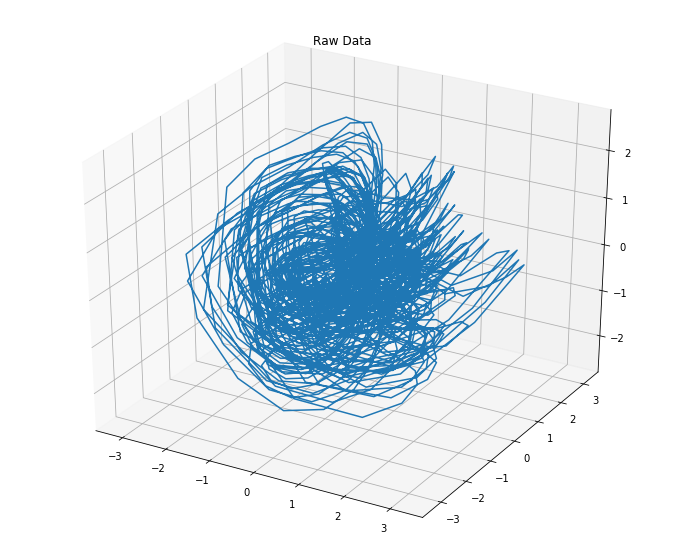

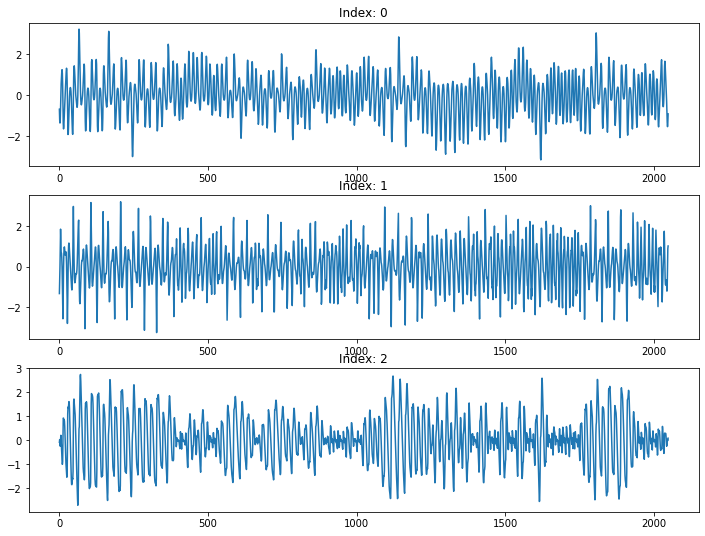

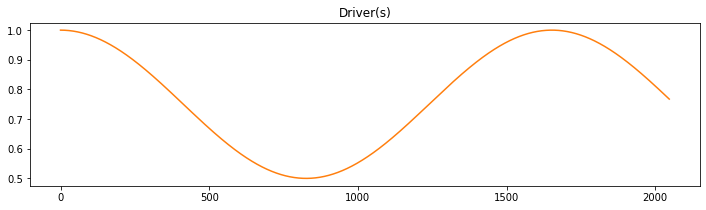

In [13]:
fig2 = plt.figure(2,figsize=(12,10))
if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
ax2.set_title("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(12,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(12,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver(s)")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
        
plt.show()

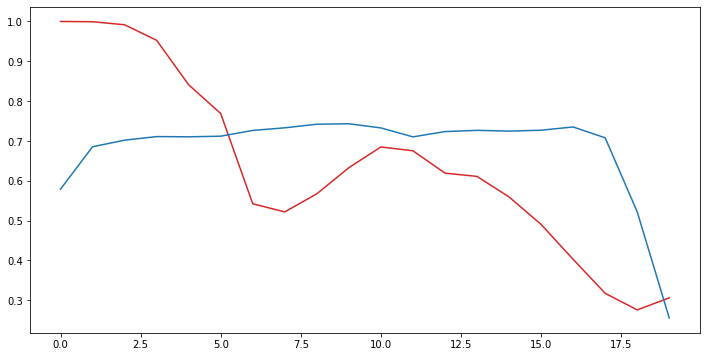

In [14]:
X = standardize(Xr[:-1,2,None])
Y = standardize(Xr[1:,2,None])
gts = standardize(gtsr[:-1])

start = 8
interval = 100
CCMValues = np.zeros( ( int((Xr.shape[0]-start)/interval), 2 ) )
for L in range(start, Xr.shape[0]-interval,interval):
    CCMValues[int((L-start)/interval), 0] = CCM(X[:L], gts[:L], 2, 1)
    CCMValues[int((L-start)/interval), 1] = CCM(gts[:L], X[:L], 2, 1)
    
    # print(CCMValues[int((L-start)/10), 0], CCMValues[int((L-start)/10), 1])

figCCM, axCCM = plt.subplots(1, figsize=(12, 3 * 2))
axCCM.plot(CCMValues[:,0], c="tab:red")
axCCM.plot(CCMValues[:,1], c="tab:blue")

plt.show()

In [15]:
# Recurrence Plot

embdim = 4
Xemb, Yemb = delayEmbed(X, Y, [embdim], 1)

"""
distances = np.zeros((Xemb.shape[0], Xemb.shape[0]))
for i in range(Xemb.shape[0]):
    for j in range(Xemb.shape[0]):
        difference = Xemb[i,:]-Xemb[j,:]
        distances[i,j] = sum(difference**2)
"""
distances = np.fromfunction(lambda i, j: la.norm(Xemb[i,:]-Xemb[j,:],axis=2),(Xemb.shape[0],Xemb.shape[0]),dtype=int)        
covarianceMatrix = np.fromfunction(lambda i, j: np.exp(-1*(la.norm(Xemb[i,:]-Xemb[j,:],axis=2)**2)*(10**0)),(Xemb.shape[0],Xemb.shape[0]),dtype=int)
# covarianceMatrix = np.fromfunction(lambda i, j: np.exp(-1*(la.norm(Xemb[i,:]-Xemb[j,:],axis=2)**2)*(10**-10))/np.sqrt(1+abs(i-j)/1000),(Xemb.shape[0],Xemb.shape[0]),dtype=int)
# covarianceMatrix = np.exp(-1 * (distances**2) / 10) + np.identity(distances.shape[0]) * 0.2# exponential covariance function
# covarianceMatrix = (1 - ((distances / (np.ptp(distances)*4)) ** (4))) * 2 * np.std(Xemb) << this one sucks

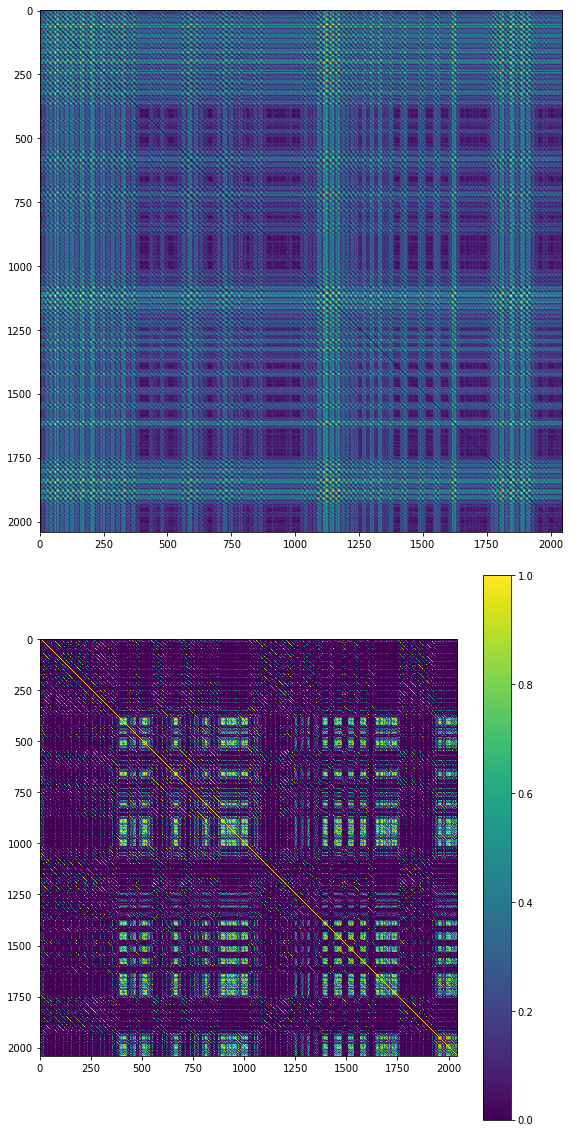

In [16]:
# Wow so recurrence plots are the real shit aren't they?
# 
figRec, axRec = plt.subplots(2, figsize=(8,16))
# axRec.pcolormesh(Xemb, Xemb, distances)
axRec[0].imshow(distances)
plot = axRec[1].imshow(covarianceMatrix)
figRec.colorbar(plot)
plt.tight_layout()
plt.show()

In [17]:
# Smoothing Done Properly I think
"""
smoothing = 10 ** 2
smoothed = covarianceMatrix @ la.inv(covarianceMatrix+smoothing*np.identity(covarianceMatrix.shape[0])) @ Yemb

figSmooth, axSmooth = plt.subplots(1,figsize=(10,6))
axSmooth.plot(smoothed)
plt.show()
"""

'\nsmoothing = 10 ** 2\nsmoothed = covarianceMatrix @ la.inv(covarianceMatrix+smoothing*np.identity(covarianceMatrix.shape[0])) @ Yemb\n\nfigSmooth, axSmooth = plt.subplots(1,figsize=(10,6))\naxSmooth.plot(smoothed)\nplt.show()\n'

In [20]:
# Smoothing via Heat Dispersion - this idea is silly and only slightly works but I like it
# du/dt = u * d^2 u / dt^2, I think this can be done via local averaging

nIterations = 1
radius = 100
dispersedCovMatrix = np.copy(covarianceMatrix)
n = dispersedCovMatrix.shape[0]

weights = np.fromfunction(lambda i,j: np.exp(-1*((radius-i)**2+(radius-j)**2)/(radius/2)**2),(2*radius+1, 2*radius+1))

for i in range(nIterations):
    # print(i ,end=' ')
    tmpCovMatrix = np.copy(dispersedCovMatrix)
    for x in range(dispersedCovMatrix.shape[0]):
        for y in range(dispersedCovMatrix.shape[1]):
            shrunkenCovMatrix = tmpCovMatrix[max(0,x-radius):min(n,x+radius+1),max(0,y-radius):min(n,y+radius+1)]
            shrunkenWeights = weights[max(0,radius-x):weights.shape[0]+min(0,n-radius-1-x),max(0,radius-y):weights.shape[0]+min(0,n-radius-1-y)]
            # print(shrunkenCovMatrix.shape,shrunkenWeights.shape)
            dispersedCovMatrix[x,y] = np.average(shrunkenCovMatrix, weights=shrunkenWeights)
            
    dispersedCovMatrix = (dispersedCovMatrix - np.min(dispersedCovMatrix)) / np.ptp(dispersedCovMatrix)


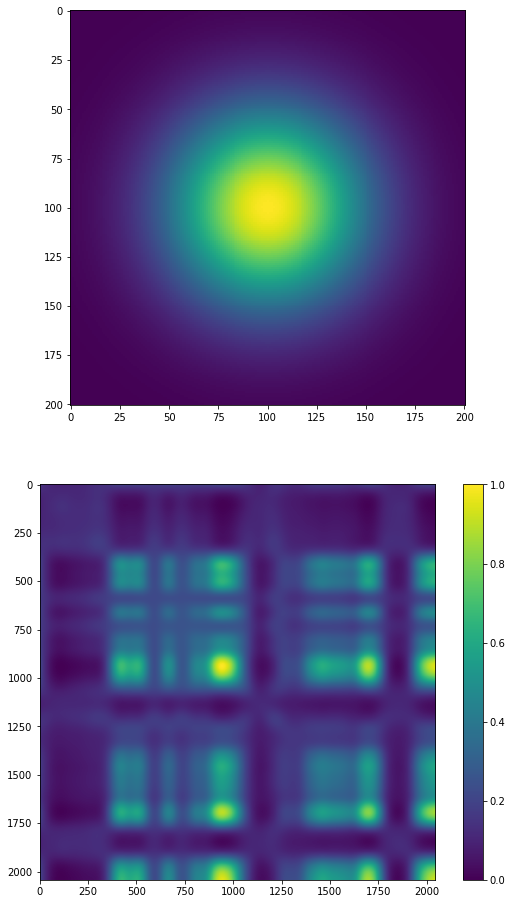

In [21]:
figHeat, axHeat = plt.subplots(2, figsize=(10,16))

axHeat[0].imshow(weights)
heatPlot = axHeat[1].imshow(dispersedCovMatrix)
plt.colorbar(heatPlot)
plt.show()

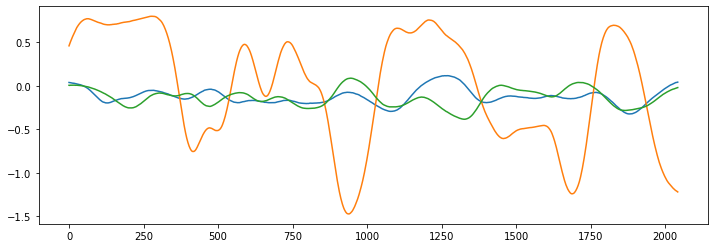

In [22]:
# draw some of them putative drivers

nDrivers = 3
size = gts.shape[0]
figDrivers, axDrivers = plt.subplots(1,figsize=(12,4))

smoothness = 6
putativeDriverCovarMatrix = dispersedCovMatrix
# putativeDriverCovarMatrix = np.fromfunction(lambda i, j: np.exp((-1*abs(i-j)**2)*(10**-smoothness)),(size,size),dtype=float) # + np.identity(size) * 10

# axDrivers[0].imshow(putativeDriverCovarMatrix)
for i in range(nDrivers):
    axDrivers.plot(rand.multivariate_normal(np.zeros(putativeDriverCovarMatrix.shape[0]),putativeDriverCovarMatrix))
plt.show()

In [324]:
# test to see whether CCM from state to putative driver corresponds closely to correlation between 
# putative and true driver

ntrials = 100
correlation = np.zeros(ntrials)
CCMReverseValues = np.zeros(ntrials)
CCMvalues = np.zeros(ntrials)
putativeDrivers = np.zeros((ntrials,X.shape[0]))
bestPutativeDriverObjectively = np.zeros(X.shape[0])

for t in range(ntrials):
    # driver is just some nice brownian motion
    # putativeDriver = np.cumsum(rand.normal(0,1,Xemb.shape[0])-0.5).reshape((Xemb.shape[0],1))
    # putativeDriver = np.cumsum(rand.rand(X.shape[0])-0.5).reshape((X.shape[0],1))
    # putativeDriver = np.real(fft.ifft(rand.rand(5),n=X.shape[0]))
    # putativeDriver = rand.multivariate_normal(np.zeros(covarianceMatrix.shape[0]),covarianceMatrix)
    putativeDriver = rand.multivariate_normal(np.zeros(putativeDriverCovarMatrix.shape[0]),putativeDriverCovarMatrix)
    putativeDriver = standardize(putativeDriver)
    
    newCorrelation = np.dot(putativeDriver.flatten(), gts) / (la.norm(putativeDriver) * la.norm(gts))
    newCCM = CCM(X, putativeDriver, embdim, 1)
    newCCMReverse = CCM(putativeDriver.reshape((X.shape[0],1)), X, embdim, 1)
    
    putativeDrivers[t] = putativeDriver
    correlation[t] = newCorrelation
    CCMvalues[t] = newCCM
    CCMReverseValues[t] = newCCMReverse

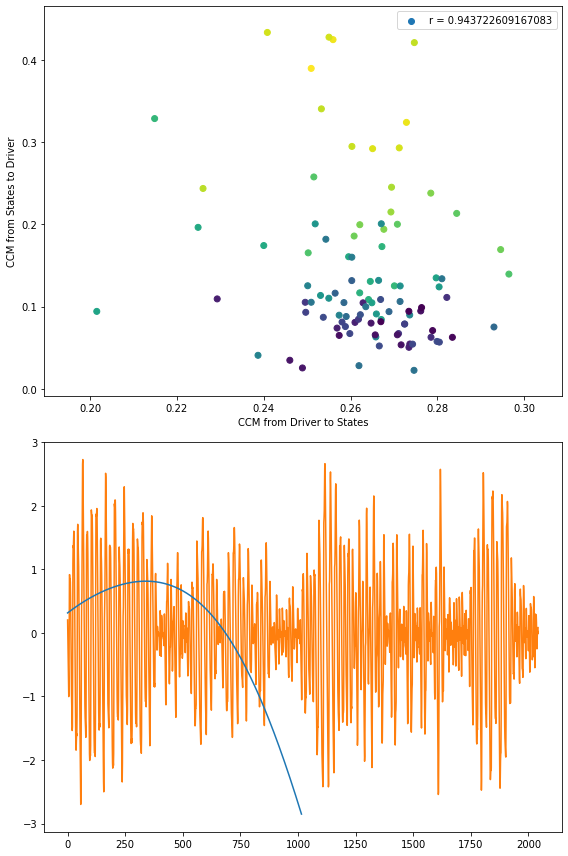

In [326]:
figBrown, axBrown = plt.subplots(2,figsize=(8,12))
axBrown[0].scatter(CCMReverseValues,CCMvalues,c=abs(correlation))
axBrown[0].set_xlabel("CCM from Driver to States")
axBrown[0].set_ylabel("CCM from States to Driver")
axBrown[0].legend(["r = {R}".format(R=np.dot(abs(correlation),CCMvalues)/(la.norm(abs(correlation))*la.norm(CCMvalues)))])

axBrown[1].plot(standardize(Yemb),c="tab:orange")
axBrown[1].plot(standardize(bestPutativeDriver),c="tab:blue")
# axBrown[1].plot(standardize(bestPutativeDriverObjectively),"--",c="tab:red")

plt.tight_layout()
plt.show()

In [ ]:
neighborRecurrentDistances = distances * np.NaN
nNeighbors = 8

for i in range(distances.shape[0]):
    neighborIndices = np.argsort(distances[i,:])[1:nNeighbors+1]
    # print(distances[i,neighborIndices])
    for ni in neighborIndices:
        neighborRecurrentDistances[i, ni] = 1
        neighborRecurrentDistances[ni, i] = 1   

driverRecurrencePlot = createRecurrencePlot(gtsr[8:])

In [ ]:
figNeighborRecurrent, axNeighborRecurrent = plt.subplots(3,figsize=(8,24))
plt1 = axNeighborRecurrent[0].imshow(neighborRecurrentDistances)
plt2 = axNeighborRecurrent[1].imshow(driverRecurrencePlot)
plt3 = axNeighborRecurrent[2].imshow((driverRecurrencePlot) * neighborRecurrentDistances)

# figNeighborRecurrent.colorbar(plt1)
# figNeighborRecurrent.colorbar(plt2)
# figNeighborRecurrent.colorbar(plt3)

plt.show()

In [ ]:
recurrencePlotFourier = fft.fft2(distances)

figFFT, axFFT = plt.subplots(1, figsize=(8,8))
axFFT.imshow(np.real(recurrencePlotFourier[1:100,1:100]))
plt.show()

In [ ]:
# Idea: use the distance matrix above as a covariance matrix in 
# a Gaussian process.


In [ ]:
# driverCovarianceMatrix = np.exp(-1*driverRecurrencePlot) * (np.std(driverRecurrencePlot) ** 2)
driverCovarianceMatrix = -2 * (driverRecurrencePlot - np.min(driverRecurrencePlot)/2)

ndrivers = 50
figDriverGP, axDriverGP = plt.subplots(1)

for i in range(ndrivers):
    putativeDriver = rand.multivariate_normal(np.zeros(driverCovarianceMatrix.shape[0]),driverCovarianceMatrix)
    axDriverGP.plot(putativeDriver)
plt.show()

In [ ]:
# CCM Monte Carlo
"""
periods = np.linspace(0, 2, 9)
amplitudes = np.linspace(0, 2, 9)
periodMesh, amplitudeMesh = np.meshgrid(periods, amplitudes)

CCMResultsToDriver = periodMesh * 0
CCMResultsFromDriver = periodMesh * 0
DriverCorrelations = periodMesh * 0

for p in range(periods.shape[0]):
    for a in range(p, amplitudes.shape[0]):
        putativeDriver = np.fromfunction(lambda i : 4*(np.cos(amplitudeMesh[p,a]*2*np.pi*i/tlen) + np.cos(periodMesh[p,a]*2*np.pi*i/tlen)), (Xr.shape[0],) , dtype = float).reshape(Xr.shape[0],1)
        CCMResultsToDriver[p,a] = CCM(X, putativeDriver, 3, 1)
        CCMResultsFromDriver[p,a] = CCM(putativeDriver, X, 3, 1)
        DriverCorrelations[p,a] = np.dot(putativeDriver.flatten(), gtsr.flatten()) / (la.norm(putativeDriver) * la.norm(gtsr))
        
        # print(CCMResultsToDriver[p,a])
        # print(CCMResultsFromDriver[p,a])
"""


In [ ]:
# print(CCMResultsToDriver)
# print(CCMResultsFromDriver)
"""
figMCCCM, axMCCCM = plt.subplots(3, figsize=(8,8*3))
axMCCCM[0].pcolormesh(periods, amplitudes, CCMResultsToDriver)
axMCCCM[0].set_title("States to Driver(should be high)")
axMCCCM[1].pcolormesh(periods, amplitudes, CCMResultsFromDriver)
axMCCCM[1].set_title("Driver to States(should be low compared to driver)")
axMCCCM[2].pcolormesh(periods, amplitudes, DriverCorrelations)
axMCCCM[2].set_title("Correlation to Driver")
"""